In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import time
from datetime import timedelta
import matplotlib.pyplot as plt

import tensorflow as tf



 
TRAIN_DIR = "DogVsCat/train"
TEST_DIR = "DogVsCat/test"
IMG_SIZE = 50
LR = 1e-3



train_data_name = 'train_dvs_data.npy'
test_data_name = 'test_dvs_data.npy'

MODEL_NAME ="DVS-{}-{}.model".format(LR,'2dconv')

In [2]:
# TRAIN_DIR1 = "notebook/convClass/DogVsCat/train"
# for img in tqdm(os.listdir("notebook")):
#                            print(img)

# path = os.path.dirname(os.path.realpath('__file__'))
# train_dir = os.path.join(path,TRAIN_DIR)
# test_dir = os.path.join(path,TEST_DIR)

In [3]:
# def label_img(img):
    
#     word_label = img.split('.')[-3]
  
#     if word_label == 'cat': return [1,0]
#     elif word_label == 'dog' : return [0,1]


In [4]:
# def create_train_data():
#     training_data = []
#     for each_img in tqdm(os.listdir(train_dir)):
#         label = label_img(each_img)
#         each_img_path = os.path.join(train_dir,each_img)
#         img_data = cv2.imread(each_img_path,cv2.IMREAD_GRAYSCALE)
#         img_data = cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
#         training_data.append([np.array(img_data),np.array(label)])
#     shuffle(training_data)
#     np.save(train_data_name,training_data)
#     return training_data


In [5]:
#create_train_data()

In [6]:
# def process_test_data():
#     testing_data = []
#     for each_img in tqdm(os.listdir(test_dir)):
#         path = os.path.join(test_dir,each_img)
#         img_num = each_img.split('.')[0]
#         img_data = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
#         img_data = cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
#         testing_data.append([np.array(img_data),img_num])
#     shuffle(testing_data)
#     np.save(test_data_name,testing_data)
#     return testing_data

In [7]:
#process_test_data()

In [8]:
#load data if exits
train_data = np.load(train_data_name)
test_data = np.load(test_data_name)


In [9]:
test_size = 0.25
testing_size = int(test_size*len(train_data))

train_x = list(train_data[:,0][:-testing_size])
train_y = list(train_data[:,1][:-testing_size])


test_x = list(train_data[:,0][-testing_size:])
test_y = list(train_data[:,1][-testing_size:])



In [10]:
len(train_x)

18750

In [11]:




filter_size = 5

num_filter1 = 32
num_filter2 = 64
num_filter3=128
num_filter4=256

keep_rate=0.8
beta=0.1




fc_size = 512
fc_size2 =1024

num_channels = 1
num_classes = 2




x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE], name='x')
y_true = tf.placeholder(tf.float32,[None,2],name ='y')


x = tf.reshape(x,[-1,IMG_SIZE,IMG_SIZE,num_channels])




save_path = 'tf_checkpoints/'



if not os.path.exists(save_path):
    os.makedirs(save_path)
    
save_validation_path = os.path.join(save_path,'best_validation')



def con2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def new_Weight(shape):
    return tf.Variable(tf.random_normal(shape))
                       
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


def new_conv_neural_layer(x,filter_size,num_channels,num_filter):
    shape = [filter_size,filter_size,num_channels,num_filter]
    weights = new_Weight(shape)
    biases = new_biases(num_filter)
    conv = con2d(x,weights) + biases
    conv = maxpool2d(conv)
    conv = tf.nn.relu(conv)
    return conv ,weights

def new_fc_layer(input,num_inputs,num_outputs,use_relu=True):
    weights = new_Weight(shape=[num_inputs,num_outputs])
    biases = new_biases(length=num_outputs)
    fc_layer = tf.matmul(input,weights)+biases
    
    if use_relu:
        fc_layer = tf.nn.relu(fc_layer)
    return fc_layer,weights



def flatten_layer(conv_output):
    layer_shape = conv_output.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flatten_conv = tf.reshape(conv_output,[-1,num_features])
    return flatten_conv,num_features


In [12]:

def build_network(dropout):
    layer_conv1,weights_conv1 = new_conv_neural_layer(x,filter_size,num_channels,num_filter1)
    layer_conv2,weights_conv2 = new_conv_neural_layer(layer_conv1,filter_size,num_filter1,num_filter2)   
    layer_conv3,weights_conv3 = new_conv_neural_layer(layer_conv2,filter_size,num_filter2,num_filter3)
    layer_conv4,weights_conv4 = new_conv_neural_layer(layer_conv3,filter_size,num_filter3,num_filter4)
    
    flatten_conv,num_feature = flatten_layer(layer_conv4)
    fc_layer1,weights_flat1 = new_fc_layer(flatten_conv,num_feature,fc_size,True)
    fc_layer2,weights_flat2 = new_fc_layer(fc_layer1,fc_size,fc_size2,True)

    if(dropout):
        fc_layer2 = tf.nn.dropout(fc_layer1,keep_rate)
    fc_layer3,weights_output = new_fc_layer(fc_layer2,fc_size2,num_classes,False)
    

    return fc_layer3,[weights_conv1,weights_conv2,weights_conv3,weights_conv4,weights_flat1,weights_flat2,weights_output]

In [13]:
def predict(y_pred_class,session):
    test_batch_size=256

    num_test = len(test_x)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    
    i = 0


    while i < num_test:
           
            
        j = min(i + test_batch_size, num_test)
            
        batch_x= np.array(test_x[i:j])
        batch_x = np.reshape(batch_x,[-1,IMG_SIZE,IMG_SIZE,1])
        batch_y= np.array(test_y[i:j])
        feed_dict = {x: batch_x,y_true:batch_y}

        cls_pred[i:j] = session.run(y_pred_class, feed_dict=feed_dict)

        i = j+1
    correct = np.equal(cls_pred,np.argmax(test_y,1))
    accuracy = np.mean(correct.astype('float'))
    
    print("validation accuracy",accuracy)
    print(correct[:100])
    return cls_pred

            
    

In [14]:

def train_model():
    
    
    prediction,list_of_weights = build_network(False)
    
    
    cross_entrpy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,
                                                                               labels=y_true))
    
    
#     regularizer = tf.nn.l2_loss(list_of_weights[0])+tf.nn.l2_loss(list_of_weights[1])+tf.nn.l2_loss(list_of_weights[2])+tf.nn.l2_loss(list_of_weights[3])+tf.nn.l2_loss(list_of_weights[4])+tf.nn.l2_loss(list_of_weights[5])+tf.nn.l2_loss(list_of_weights[6])       
    
#     cross_entrpy_loss = tf.reduce_mean(cross_entrpy_loss + beta * regularizer)
    
    
    
    optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(cross_entrpy_loss)
    batch_size = 128


    hm_epochs = 20
    with tf.Session() as sessin:
        
        saver1=tf.train.Saver()
        best_validation=0.0
        last_improvement=0
        
        y_pred = tf.nn.softmax(prediction)
        y_pred_class = tf.argmax(y_pred,dimension=1)
    
            
        sessin.run(tf.global_variables_initializer())
        start_time = time.time()
        for epoch in tqdm(range(hm_epochs)):
            epoch_loss = 0
            batch=0
            
            while batch < len(train_x):
                start = batch
                end = batch+batch_size
                batch_x = np.array(train_x[start:end])
                batch_x = np.reshape(batch_x,[-1,IMG_SIZE,IMG_SIZE,1])
                batch_y = np.array(train_y[start:end])
                _, c = sessin.run([optimizer, cross_entrpy_loss], feed_dict={x: batch_x, y_true: batch_y})
                epoch_loss += c
                batch+=batch_size
               
                

            end_time =time.time()
            difference = end_time - start_time
            print("Time usage: " + str(timedelta(seconds=int(round(difference)))))
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_true, 1))
            
           
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            acc = sessin.run(accuracy, feed_dict={x:batch_x, y_true: batch_y})
        
               
            saver1.save(sess=sessin,save_path=save_validation_path)
                
            print("last improvment at epoch",epoch+1,"with accuracy",acc)
        predict(y_pred_class,sessin)
        
            


In [15]:
train_model()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Time usage: 0:01:11
Epoch 1 completed out of 20 loss: 2.7549730775e+12
last improvment at epoch 1 with accuracy 0.596774


  5%|████▏                                                                              | 1/20 [01:12<23:04, 72.89s/it]

Time usage: 0:02:20
Epoch 2 completed out of 20 loss: 1.19641720013e+12
last improvment at epoch 2 with accuracy 0.612903


 10%|████████▎                                                                          | 2/20 [02:21<21:30, 71.68s/it]

Time usage: 0:03:29
Epoch 3 completed out of 20 loss: 732591892224.0
last improvment at epoch 3 with accuracy 0.66129


 15%|████████████▍                                                                      | 3/20 [03:30<20:05, 70.92s/it]

Time usage: 0:04:38
Epoch 4 completed out of 20 loss: 574450890240.0
last improvment at epoch 4 with accuracy 0.66129


 20%|████████████████▌                                                                  | 4/20 [04:40<18:48, 70.52s/it]

Time usage: 0:05:47
Epoch 5 completed out of 20 loss: 505780718336.0
last improvment at epoch 5 with accuracy 0.693548


 25%|████████████████████▊                                                              | 5/20 [05:49<17:31, 70.12s/it]

Time usage: 0:06:57
Epoch 6 completed out of 20 loss: 460325392384.0
last improvment at epoch 6 with accuracy 0.725806


 30%|████████████████████████▉                                                          | 6/20 [06:58<16:17, 69.82s/it]

Time usage: 0:08:06
Epoch 7 completed out of 20 loss: 374459900288.0
last improvment at epoch 7 with accuracy 0.677419


 35%|█████████████████████████████                                                      | 7/20 [08:08<15:05, 69.65s/it]

Time usage: 0:09:15
Epoch 8 completed out of 20 loss: 272686808960.0
last improvment at epoch 8 with accuracy 0.709677


 40%|█████████████████████████████████▏                                                 | 8/20 [09:17<13:54, 69.50s/it]

Time usage: 0:10:24
Epoch 9 completed out of 20 loss: 216419865984.0
last improvment at epoch 9 with accuracy 0.758065


 45%|█████████████████████████████████████▎                                             | 9/20 [10:26<12:43, 69.37s/it]

Time usage: 0:11:33
Epoch 10 completed out of 20 loss: 177229064896.0
last improvment at epoch 10 with accuracy 0.741935


 50%|█████████████████████████████████████████                                         | 10/20 [11:35<11:33, 69.38s/it]

Time usage: 0:12:43
Epoch 11 completed out of 20 loss: 205541782944.0
last improvment at epoch 11 with accuracy 0.629032


 55%|█████████████████████████████████████████████                                     | 11/20 [12:44<10:24, 69.34s/it]

Time usage: 0:13:52
Epoch 12 completed out of 20 loss: 210937002400.0
last improvment at epoch 12 with accuracy 0.83871


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:54<09:14, 69.37s/it]

Time usage: 0:15:02
Epoch 13 completed out of 20 loss: 165227310144.0
last improvment at epoch 13 with accuracy 0.887097


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [15:04<08:06, 69.49s/it]

Time usage: 0:16:11
Epoch 14 completed out of 20 loss: 124010996864.0
last improvment at epoch 14 with accuracy 0.83871


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [16:13<06:57, 69.52s/it]

Time usage: 0:17:21
Epoch 15 completed out of 20 loss: 115030089296.0
last improvment at epoch 15 with accuracy 0.741935


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [17:23<05:47, 69.47s/it]

Time usage: 0:18:30
Epoch 16 completed out of 20 loss: 98765433776.0
last improvment at epoch 16 with accuracy 0.822581


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:33<04:38, 69.62s/it]

Time usage: 0:19:40
Epoch 17 completed out of 20 loss: 87749260496.0
last improvment at epoch 17 with accuracy 0.887097


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:42<03:29, 69.70s/it]

Time usage: 0:20:50
Epoch 18 completed out of 20 loss: 77749969752.0
last improvment at epoch 18 with accuracy 0.951613


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [20:52<02:19, 69.65s/it]

Time usage: 0:22:00
Epoch 19 completed out of 20 loss: 64440955460.0
last improvment at epoch 19 with accuracy 0.967742


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [22:01<01:09, 69.55s/it]

Time usage: 0:23:09
Epoch 20 completed out of 20 loss: 68428627856.0
last improvment at epoch 20 with accuracy 0.967742


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:11<00:00, 69.54s/it]


validation accuracy 0.64032
[False  True False False  True False  True  True  True  True  True  True
  True False  True  True  True False  True  True False False  True  True
  True False  True  True False  True  True  True  True  True  True  True
  True False  True  True  True  True False False False False  True  True
  True  True False  True False False  True  True  True  True  True  True
 False False  True False False False False  True  True  True False False
 False  True False  True False  True  True  True  True  True False  True
  True  True  True False  True False  True  True  True  True False False
 False False  True  True]


In [16]:
print("hello")

hello


In [17]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


Tensor("add_27:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from tf_checkpoints/best_validation
[1 0 0 1 0 0 1 1 1]


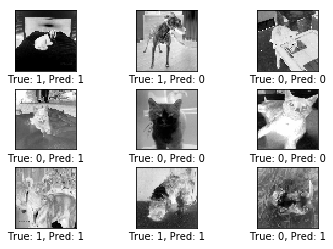

In [20]:

prediction,list_of_weights = build_network(False)
print(prediction)
y_pred = tf.nn.softmax(prediction)



y_pred_class = tf.argmax(y_pred,dimension=1)

batch_n= np.array(test_x[5634:5643])
batch_x = np.reshape(batch_n,[-1,IMG_SIZE,IMG_SIZE,1])
batch_y=np.array(test_y[5634:5643])
batch_y = np.argmax(batch_y,1)



    
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())

    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver2= tf.train.import_meta_graph("{}.meta".format(ckpt.model_checkpoint_path))
        saver2.restore(sess, ckpt.model_checkpoint_path)
    else:
        print("No checkpoint")
    feed_dict = {x: batch_x}

    cls_pred = sess.run(y_pred_class, feed_dict=feed_dict)
print(cls_pred)
plot_images(batch_n,batch_y,cls_pred)
